# Pilot data check - TODO

- frame rate/subject
- number of grasps/subject
- number of eye samples/object
- number of eye samples/grasped object
- number of eye samples/grasped object/sorting type --> shouldn't be different
- number of samples with NaN
- **validation error across trials/subject**
- azimuth and elevation angles/subject (histograms)
- Amplitude of head movements based on velocity
- Saccade amplitude based on velocity

In [1]:
# %pip install pprint
# fill this value to sun script for that particular subject
subjectID = '2001'

In [2]:
import ProtobufTypes_pb2 
import pandas as pd
import sys
import json
import inspect
from google.protobuf.json_format import MessageToDict
import collections
import numpy as np
import glob
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle
import pprint
from IPython.display import display

PLOT_DIR = './PLOTS/'
os.makedirs(os.path.dirname(PLOT_DIR), exist_ok=True)
sns.set(context = "talk", style="white", palette="dark", font_scale=1, rc={'figure.figsize':(11.7,8.27)})
COLORS = {'g': '#CAE6CB', 'r': '#E6CACA', 'b': '#C9D4F5'}

In [3]:
# pickle the data
def pickleData(filepath,filename, data):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(str(filepath+filename),'wb') as fh:
        pickle.dump(data,fh)

# read from pickled data
def read_dataFrameFromFile(filename):
    with open(filename, 'rb') as fh:
        dataframe = pickle.load(fh)
    return dataframe

#Flatten the dictionary for easy df conversion
def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        nk = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, nk, sep=sep).items())
        else:
            items.append((nk,v))
    return dict(items)

def flatten(d, parent_key='', sep='_'):
    items = []
    if isinstance(d, dict):
        for k, v in d.items():
            nk = parent_key + sep + k if parent_key else k
            if isinstance(v, collections.MutableMapping):
                items.extend(flatten(v, nk, sep=sep).items())
            else:
                items.append((nk,v))
    return dict(items)

In [4]:
protobuf_obj = ProtobufTypes_pb2.EyetrackingDataSet()
files = glob.glob("./subject*.etd")
print(files)

['./subject1004.etd', './subject1001.etd', './subject1002.etd', './subject1003.etd', './subject1005.etd', './subject1006.etd', './subject1006_1.etd', './subject1007.etd', './subject1007_1.etd', './subject1008.etd', './subject1009.etd', './subject1011.etd', './subject2003.etd', './subject60.etd', './subject2001.etd', './subject2003_1.etd', './subject2005.etd', './subject2002.etd', './subject2004.etd']


In [5]:
# Read Subject data
val_df= pd.DataFrame()
with open('subject{}.etd'.format(subjectID), "rb") as f:
    protobuf_obj.ParseFromString(f.read())
dict_obj = MessageToDict(protobuf_obj)
val_df = pd.io.json.json_normalize(dict_obj['validationSamples'])
# pickleData('./Data/subject{}/'.format(subjectID),'validationData',val_df)
val_df.columns

Index(['timestamp', 'validationTrial', 'validationPointIdx',
       'leftEyeAngleOffset.x', 'leftEyeAngleOffset.y', 'leftEyeAngleOffset.z',
       'rightEyeAngleOffset.x', 'rightEyeAngleOffset.y',
       'rightEyeAngleOffset.z', 'combinedEyeAngleOffset.x',
       'combinedEyeAngleOffset.y', 'combinedEyeAngleOffset.z',
       'unixTimestamp.seconds', 'headTransform.position.x',
       'headTransform.position.y', 'headTransform.position.z',
       'headTransform.rotation.x', 'headTransform.rotation.y',
       'headTransform.rotation.z', 'headTransform.rotation.w',
       'headTransform.scale.x', 'headTransform.scale.y',
       'headTransform.scale.z', 'pointToFocus.x', 'pointToFocus.y',
       'pointToFocus.z'],
      dtype='object')

In [6]:
#change angles to be within 180 degrees
sel_columns = ['combinedEyeAngleOffset.x', 'combinedEyeAngleOffset.y','combinedEyeAngleOffset.z',
               'leftEyeAngleOffset.x', 'leftEyeAngleOffset.y','leftEyeAngleOffset.z',
               'rightEyeAngleOffset.x', 'rightEyeAngleOffset.y','rightEyeAngleOffset.z']

for col in sel_columns:
    val_df.loc[val_df[col]>360, col] = val_df[col] - 360
    val_df.loc[val_df[col]>180, col] = 360 - val_df[col]


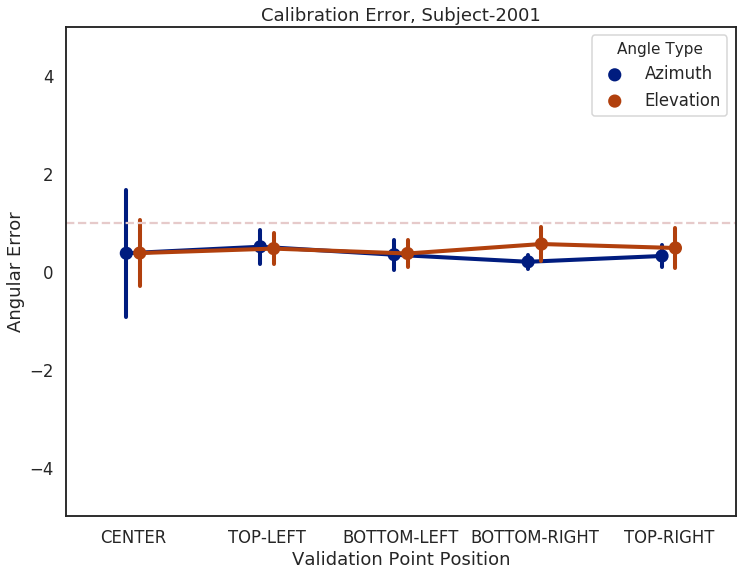

In [7]:
%matplotlib inline
tmpdf = (
            val_df
            .melt(id_vars='validationPointIdx', 
                  value_vars=['combinedEyeAngleOffset.x', 'combinedEyeAngleOffset.y'],
                  var_name='Angle Type', value_name='Angular Error')
        )
# display(tmpdf.head())
tmpdf['Angle Type'].replace({'combinedEyeAngleOffset.x': 'Azimuth', 'combinedEyeAngleOffset.y':'Elevation'}, inplace=True)
tmpdf['validationPointIdx'].replace({1: 'CENTER', 2:'TOP-LEFT', 3: 'BOTTOM-LEFT',
                                        4:'BOTTOM-RIGHT', 5:'TOP-RIGHT'}, inplace=True)


fig, ax = plt.subplots(1,1,figsize=(12,9))
sns.pointplot( data=tmpdf, x='validationPointIdx', y='Angular Error', hue='Angle Type', 
            ci='sd', dodge=0.1, ax=ax)
ax.set_ylim(-5, 5)
ax.axhline(1, color=COLORS['r'], linestyle='--')
ax.set_xlabel('Validation Point Position')
ax.set_title('Calibration Error, Subject-{}'.format(subjectID))
plt.savefig(PLOT_DIR+'/validation_error_positions_{}.png'.format(subjectID), quality=90)

In [8]:
# raise

RuntimeError: No active exception to reraise

<IPython.core.display.Javascript object>


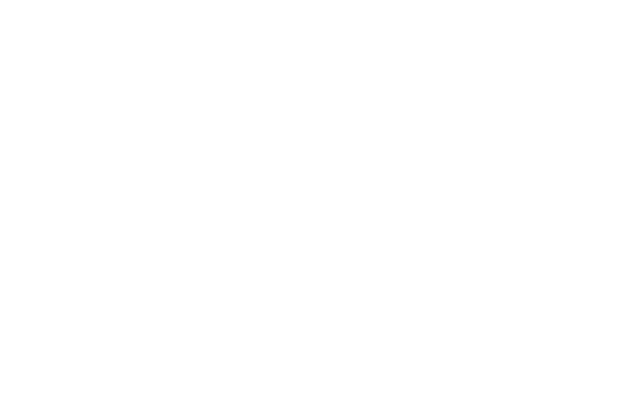

<IPython.core.display.Javascript object>


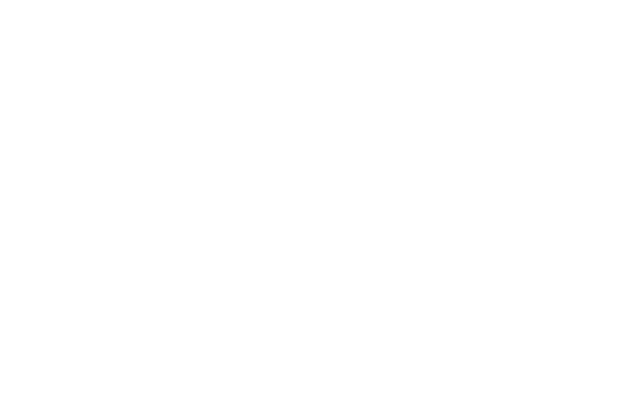

In [9]:
# %matplotlib notebook
ax = val_df.loc[:,['combinedEyeAngleOffset.x','combinedEyeAngleOffset.y']]\
                                            .plot.kde(title='Angular error for Cyclopean eye SUBJECT-{}'.format(subjectID))
ax.set_xlabel('Angle in degrees')
ax.set_xlim((-5,20))
ax.axvline(1, linestyle='--', color=COLORS['r'])
ax.legend(['Azimuth', 'Elevation'])
plt.savefig(PLOT_DIR+'/validation_error_{}.png'.format(subjectID), quality=90)

<IPython.core.display.Javascript object>


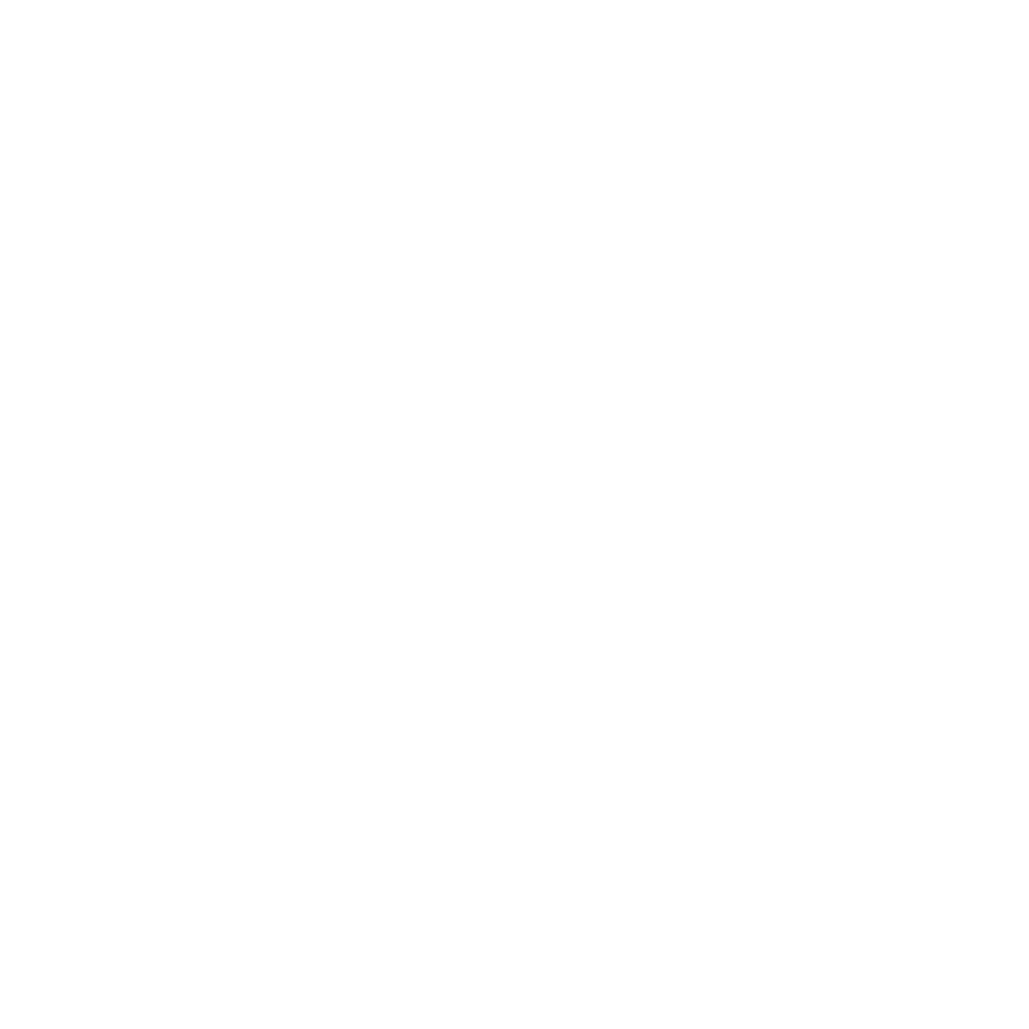

Text(0.5, 0.998, 'Calibration Errors For Different Positions SUBJECT-2001')

<IPython.core.display.Javascript object>


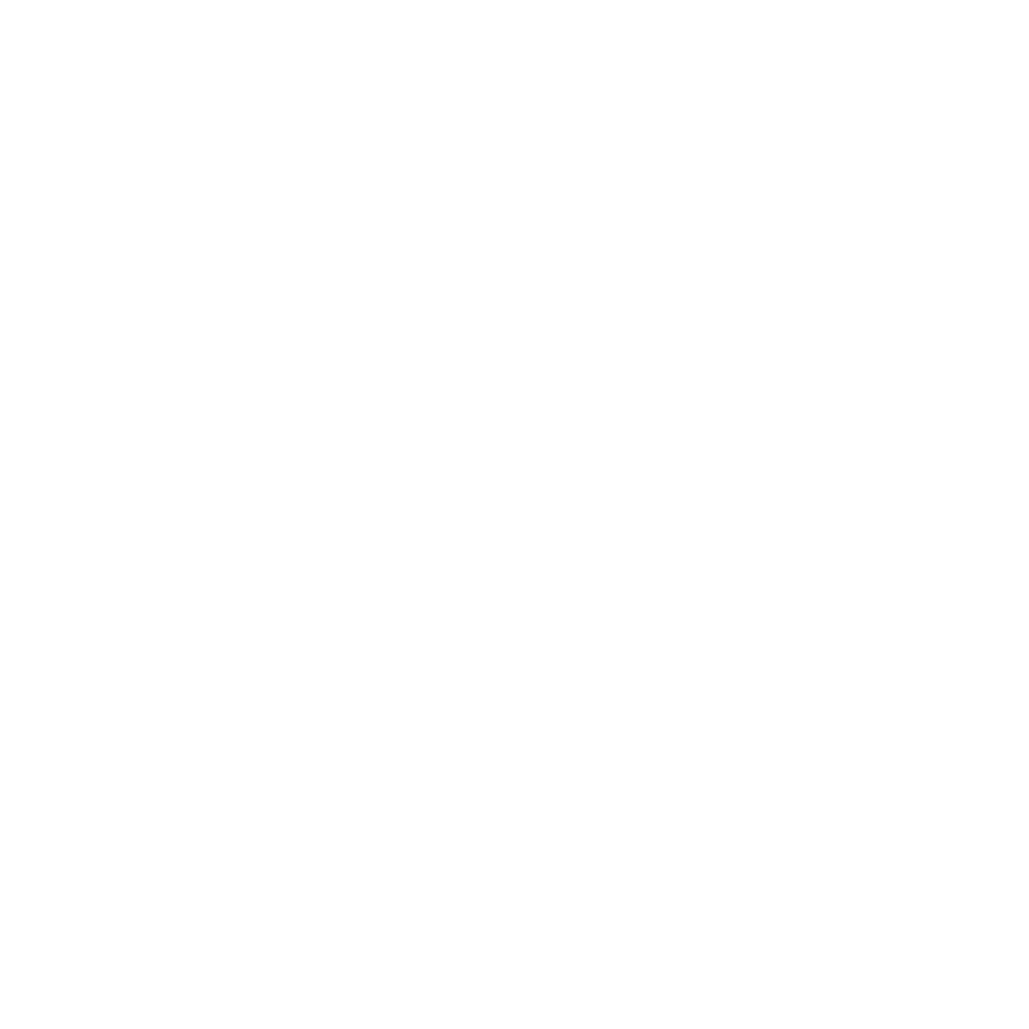

In [11]:
# %matplotlib inline
fig = plt.figure(figsize=(10,10))
# plt.subplots_adjust(bottom=0.2)
ax = sns.pointplot(data = val_df, x='validationPointIdx', y='combinedEyeAngleOffset.x', ci='sd', color='b')
ax.set_label('Azimuth')
ax = sns.pointplot(data = val_df, x='validationPointIdx', y='combinedEyeAngleOffset.y', ci='sd', color='r')
ax.set_xlabel('Validation Point Index')
ax.set_ylabel('Calibration Error ($^\circ$) ')
ax.set_ylim(-10,10)
ax.set_yticks((-10,-5,0,5,10))
ax.axhline(1, linestyle='--', color = COLORS['b'])
ax.set_label('Elevation')
ax.legend(['Azimuth', 'Elevation'])
plt.title('Calibration Errors For Different Positions SUBJECT-{}'.format(subjectID), fontsize=20,x=0.5, y=0.998)
# plt.savefig(PLOT_DIR+'/validation_error_positions_{}.png'.format(subjectID), quality=90)

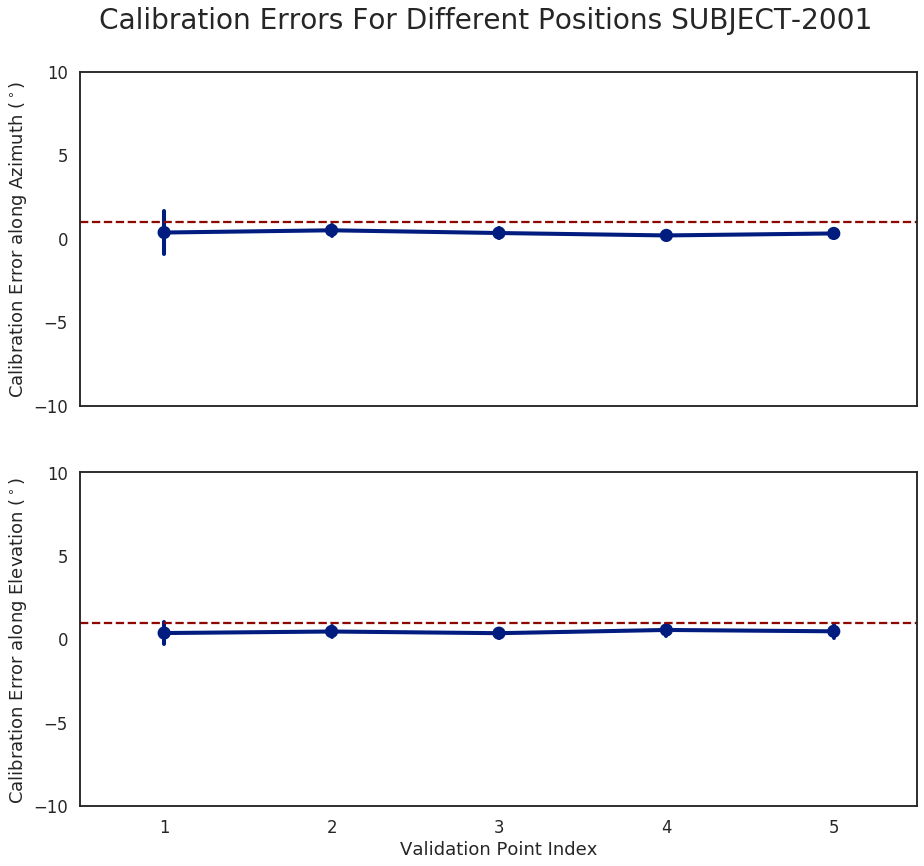

In [12]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(15,15), sharex=True)
plt.subplots_adjust(bottom=0.2)
sns.pointplot(data = val_df, x='validationPointIdx', y='combinedEyeAngleOffset.x', ci='sd', ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Calibration Error along Azimuth ($^\circ$) ')
ax[0].set_ylim(-10,10)
ax[0].set_yticks((-10,-5,0,5,10))
ax[0].axhline(1, linestyle='--', color = 'r')
sns.pointplot(data = val_df, x='validationPointIdx', y='combinedEyeAngleOffset.y', ci='sd', ax=ax[1])
ax[1].set_xlabel('Validation Point Index')
ax[1].set_ylabel('Calibration Error along Elevation ($^\circ$) ')
ax[1].set_ylim(-10,10)
ax[1].set_yticks((-10,-5,0,5,10))
ax[1].axhline(1, linestyle='--', color = 'r')
plt.suptitle('Calibration Errors For Different Positions SUBJECT-{}'.format(subjectID), fontsize=28,x=0.5, y=0.94)
plt.savefig(PLOT_DIR+'/validation_error_positions_{}.png'.format(subjectID), quality=90)

In [13]:
del val_df # clean up memory
raise

RuntimeError: No active exception to reraise

In [14]:
eye_df = pd.DataFrame()
hand_df = pd.DataFrame()
shelf_df = pd.DataFrame()
for trialID, trialData in enumerate(MessageToDict(protobuf_obj)['trials']):
    for s_id, shelfData in enumerate(trialData['metaData']['initialConfiguration']['items']):     
        shelf_df = pd.concat([shelf_df, pd.DataFrame(shelfData, index=[s_id])], ignore_index=True, sort=False)
    for s_id, sampleData in enumerate(trialData['samples']):
        eye_df = pd.concat([eye_df, pd.DataFrame(flatten(sampleData), index=[s_id])], ignore_index=True, sort=False)
#         for h_id, handData in enumerate(sampleData['handData']):
#             hand_df = pd.concat([hand_df, pd.DataFrame(handData, index=[h_id])], ignore_index=True, sort=False)
#             hand_df['timestamp'] = sampleData['timestamp']
    eye_df['trialID'] = trialID
#     hand_df['trialID'] = trialID
    eye_df['subjectID'] = subjectID
#     hand_df['subjectID'] = subjectID
    shelf_df['trialID'] = trialID
    shelf_df['subjectID'] = subjectID

KeyboardInterrupt: 

In [ ]:
shelf_df

In [ ]:
pickleData('./Data/subject{}/'.format(subjectID),'eyeData',eye_df)
pickleData('./Data/subject{}/'.format(subjectID),'shelfdata',shelf_df)
del shelf_df
del eye_df

In [ ]:
raise

# Scratch

In [ ]:
# dict_obj = MessageToDict(protobuf_obj)
dict_obj['trials'][2]['samples'][1]['handData']

In [ ]:
dict_obj['trials'][1]['samples']

In [ ]:
eye_df.trialID.value_counts()